In [1]:
import pandas as pd
import numpy as np
from collections import defaultdict
from sklearn.model_selection import train_test_split
import ast
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from matplotlib import pyplot
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score
from sklearn.metrics import auc

# Choose the Organization of Interest

In [38]:
org = "USC"
# org = "TAM"
# org = "OKLAHOMA"
# org = "BAYLOR"
# org = "ECU"
# org = 'UT-A'

# Load Account Data

In [39]:
# Load Account Data For a Specific Organization
account = pd.read_csv("tag/acc_tags_set.csv")
account = account[account.org_id==org].copy()
account.drop(columns = ["nan_tag"], inplace = True)

interested_tags = set()
acc_tag_dict = defaultdict(int)
for i in range(len(account)):
    tag_list = ast.literal_eval(account.tags.iloc[i])
    for t in tag_list:
        acc_tag_dict[t]+=1
        interested_tags.add(t)
account_per_tag = []
for k,v in acc_tag_dict.items():
    account_per_tag.append({"tag":k,"counts":v })
account_per_tag = pd.DataFrame(account_per_tag)

# Load Seasonal Ticket Data

In [27]:
ticket_season = pd.read_csv("ticket_trans_item_event.csv")

In [28]:
ticket_season = ticket_season[ticket_season.org_id.isin([org])].copy()
ticket_orgs = ticket_season.org_id.unique()

In [29]:
ticket_season.to_csv(f"{org}_ticket_trans_item_event.csv", index = False)

In [40]:
ticket_season = pd.read_csv(f"{org}_ticket_trans_item_event.csv")

# Preprocess Data

In [9]:
import statsmodels.api as sm
from scipy import stats

## Only select the tags that have been assigned to more than 100 accounts

In [41]:
useful_tags = []
error_tags = []
# method = "logit"

for i,tag in enumerate(interested_tags):
    if type(tag)==str and account_per_tag[account_per_tag.tag==tag].iloc[0]["counts"] >100:
        useful_tags.append(tag)

## Pivot Wide Table so that each column is a season of the organization

In [42]:
ticket_season_org = ticket_season[["account_id","org_id","season","total_epay",
                                   "e_oqty"]].groupby(["account_id","org_id",
                                                       "season"]).sum().reset_index()
ticket_season_org = ticket_season_org.pivot(index = ["account_id","org_id"], 
                           columns = ["season"],
                           values = ["total_epay","e_oqty"]).fillna(0)
ticket_season_org.columns = ["_".join(x) if x[0] not in ["account_id","org_id"] else x[0] for x in ticket_season_org.columns.ravel()]
temp = pd.merge(account,ticket_season_org, on = ["account_id","org_id"], how = "inner")
temp.fillna(0,inplace = True)

In [59]:
ticket_season_org[ticket_season_org.total_epay_B17>0].reset_index()


,account_id,org_id,total_epay_AE17,total_epay_AE18,total_epay_AE19,total_epay_AE20,total_epay_B15,total_epay_B16,total_epay_B17,total_epay_B18,...,e_oqty_PO17,e_oqty_POS18,e_oqty_POS19,e_oqty_R18,e_oqty_R19,e_oqty_S18,e_oqty_S19,e_oqty_VB17,e_oqty_VB18,e_oqty_VB19
0,6.000000e+00,USC,0.0,0.0,0.0,0.0,0.0,0.0,2130.0,3120.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,40.0,126.0,62.0
1,8.000000e+00,USC,0.0,0.0,0.0,0.0,0.0,0.0,2440.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,82.0,50.0
2,1.100000e+01,USC,0.0,0.0,0.0,0.0,0.0,0.0,4692.0,6060.0,...,306.0,0.0,0.0,0.0,0.0,0.0,0.0,40.0,175.0,50.0
3,2.400000e+01,USC,0.0,0.0,0.0,0.0,0.0,0.0,3629.0,1609.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,50.0,50.0
4,2.500000e+01,USC,0.0,0.0,0.0,0.0,0.0,0.0,2805.0,3442.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,50.0,69.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2454,9.832317e+09,USC,0.0,0.0,0.0,0.0,0.0,0.0,10.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2455,9.885212e+09,USC,0.0,0.0,0.0,0.0,0.0,0.0,282.0,104.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2456,9.895959e+09,USC,0.0,0.0,0.0,0.0,0.0,0.0,350.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2457,9.930844e+09,USC,0.0,0.0,0.0,0.0,0.0,0.0,288.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Logistic Regression & Simple Linear Regression

In [44]:
from sklearn.metrics import (confusion_matrix, accuracy_score)
from sklearn import metrics


In [102]:
def get_roc(testy, pred_y, org , tag):
    ns_probs = [0 for _ in range(len(testy))]
    # calculate scores
    ns_auc = roc_auc_score(testy, ns_probs)
    lr_auc = roc_auc_score(testy, pred_y)
    # summarize scores
    print('No Skill: ROC AUC=%.3f' % (ns_auc))
    print('Logistic: ROC AUC=%.3f' % (lr_auc))
    # calculate roc curves
    ns_fpr, ns_tpr, _ = roc_curve(testy, ns_probs)
    lr_fpr, lr_tpr, _ = roc_curve(testy, pred_y)
    return lr_auc,ns_fpr, ns_tpr,lr_fpr, lr_tpr

def plot_roc(ns_fpr, ns_tpr,lr_fpr, lr_tpr, tag, org):
    
    colors = ["#2CBDFE","#47DBCD","#F3A0F2","#9D2EC5","#F5B14C"]
    # plot the roc curve for the model
    for i,(lf, lt,color) in enumerate(zip(lr_fpr, lr_tpr, colors)):      
        pyplot.plot(lf, lt, marker='.', label=f'CV {i+1}', color=color )
    pyplot.plot(ns_fpr[0], ns_tpr[0], linestyle='dashdot', label='Logistic',color = "black")
    # axis labels
    pyplot.xlabel('False Positive Rate')
    pyplot.ylabel('True Positive Rate')
    # show the legend
    pyplot.legend()
    
    pyplot.title(f"ROC Curve for Tag {tag} in {org}")
    # save image
    pyplot.savefig(f'ROC/{org}_{tag}.png',bbox_inches='tight')
    
    # show the plot
    
    pyplot.show()
#     return lr_auc

In [103]:
def calculate_season_slm(tag, org):
    '''Get 5-fold Cross Validation Result for Logistic Regression in predicting whether the accounts
    in a selected organization are assigned a selected tag.
    Get the account and ticket data from previous codes to avoid copying too many data and crashing the session
    '''
    print("Selected Tag:", tag)
#     ----------------------------------Preprocess Data ----------------------------------
#     Ticket Season: Number of Columns
    print("old columns number:",len(ticket_season_org.columns))
    
#     Account Data: Create Target Column to indicate whether and again return 0 if 
    tag_account = account.copy()
    tag_account["tag"] = tag_account.tags.str.contains(tag).fillna(False)
    tag_num = len(tag_account[tag_account.tag])
    if tag_num<100:
        print("tag_num:",tag_num)
        return 0
    
#     Merge Account + Ticket Season    
    temp = pd.merge(tag_account,ticket_season_org, on = ["account_id","org_id"], how = "left")
    total_number_of_account = len(temp)
    total_number_of_acc_w_tag = len(temp[temp.tag])
    print("total number of accounts labeled with tag:", total_number_of_acc_w_tag)
    print("total number of accounts: ",total_number_of_account)
    print("percentage of tags:",total_number_of_acc_w_tag/total_number_of_account)
    
    if len(temp[temp.tag])<100:     
        return 0
    
    temp.fillna(0,inplace = True)   
    
#     Drop Season Columns if fewer than 1000 accounts have bought relevant tickets:
    temp["intercept"] = 1
    temp.drop(columns = ["tags"], inplace = True)
    drop_cols = []
    for c in temp.columns:
        if c not in ["account_id","org_id",'tag']:
            if len(temp[temp[c]>0])<1000:
                drop_cols.append(c)
    print(drop_cols)
    temp.drop(columns = drop_cols, inplace = True)
    
#     The X variable Columns
    xs = [c for c in temp.columns if c not in ["account_id","org_id",'tag']]
    print("new columns number:",len(xs))

#     Randomize the dataframe with sample and fraction = 1 and replace = False
    np.random.seed(0)
    temp = temp.sample(frac=1).reset_index(drop=True)
    
#     -----------------------------------------------------------------------------------------
# --------- Run Logistic REGRESSION on all data to get the table for p-value and coefficient---------
#         Need to use bfgs else errors will be very frequent
    overall_result=sm.Logit(temp.tag, temp[xs]).fit(method='bfgs')
    print(overall_result.summary())
    
#    -------------------------------------------------------------------------------------------    
#     ------------------5-FOLD Cross Validation Data Preprocess-------------------

#     Split the data with tag from no tag for future 5-fold splitting
    temp_tag = temp[temp.tag].copy()
    temp = temp[~temp.tag]

#     # Tags Train Split - index
    arr_tags = np.arange(len(temp_tag))
    np.random.seed(0)
    np.random.shuffle(arr_tags)
    arr_tags=np.array_split(arr_tags, 5)
    
#     # Not Tags Train Split - index
    arr_no_tags = np.arange(len(temp))
    np.random.seed(0)
    np.random.shuffle(arr_no_tags)
    arr_no_tags=np.array_split(arr_no_tags, 5)
    
    temp.reset_index(inplace = True)
    temp_tag.reset_index(inplace = True)

#     ------------------5-FOLD Cross Validation and Metrics-------------------
    
    average_mse =0
    avg_specificity = 0
    avg_sensitivity = 0
    avg_f1 = 0
    sense_gd=True
    spec_gd = True
    avg_auc_score=0
    ns_fprs, ns_tprs,lr_fprs, lr_tprs = [],[],[],[]
    for i,(ari1, ari2) in enumerate(zip(arr_no_tags, arr_tags)):
#         Train Test split using the previously prepared indexes in each fold
        temp_test = pd.concat([temp.iloc[ari1],
                             temp_tag.iloc[ari2]]).reset_index()
        temp_tr = pd.concat([temp.drop(ari1,axis =0),
                               temp_tag.drop(ari2,axis =0)])
        temp_tr = temp_tr.sample(frac=1).reset_index(drop=True)


#       Train Logistic Regression Model 
        result=sm.Logit(temp_tr.tag, temp_tr[xs]).fit(method='bfgs')

#       Prediction
        predicted = result.predict(temp_test[xs])
    
#       Calculate AUC Score and Plot ROC Curve
        auc_score, ns_fpr, ns_tpr,lr_fpr, lr_tpr = get_roc(temp_test.tag, predicted, 
                                                           org , tag)
        ns_fprs.append(ns_fpr)
        ns_tprs.append(ns_tpr)
        lr_tprs.append(lr_tpr)
        lr_fprs.append(lr_fpr)
        
#         plot_roc( temp_test.tag, predicted, org, tag, i)  
        avg_auc_score+=auc_score
#           Use 0.5 as threshold: <0.5 means no tag; >=0.5 means tag
        predicted = np.where(predicted<0.5,0,1)
        
        
        
#         Calculate Measure Metrics:
#       mse, true_positive, false_negative,true_negative,false_positive
        mse = np.sum((predicted - temp_test.tag)**2)/len( temp_test.tag)

        average_mse+=mse
        true_positive = 0
        false_negative = 0
        true_negative = 0
        false_positive= 0
        
        for i in range(len(predicted)):
            if predicted[i] and temp_test.tag.iloc[i]:
                true_positive+=1
            elif not predicted[i] and not temp_test.tag.iloc[i]:
                true_negative+=1
            elif predicted[i] and not temp_test.tag.iloc[i]:
                false_negative+=1
            else:
                false_positive+=1
        print(true_positive,false_negative,true_negative,false_positive)
        if true_positive+false_negative!=0:
            sensitivity = true_positive/(true_positive+false_negative)
            avg_sensitivity+=sensitivity
#             print(i,"sensitivity:",sensitivity)
        else:
            sense_gd=False
        if true_negative+false_positive!=0:
            specificity = true_negative/(true_negative+false_positive) 
            avg_specificity+=specificity
#             print(i,"specificity:",specificity)
        else:
            spec_gd = False
            
        avg_f1 += true_positive/(true_positive+(false_positive+false_negative)/2)
    
    print("ns_fprs:",ns_fprs)
#     print("ns_tprs:",ns_tprs)
#     print("lr_fprs:",lr_fprs)
#     print("lr_tprs:",lr_tprs)
    plot_roc( ns_fprs, ns_tprs, lr_fprs, lr_tprs, tag, org)    
    if sense_gd:
        avg_sensitivity = avg_sensitivity/5
        print("avg_sensitivity:",avg_sensitivity)
    if spec_gd:
        avg_specificity = avg_specificity/5
        print("avg_specificity:",avg_specificity)
        
    avg_f1 = avg_f1/5
    print("avg_f1 score:", avg_f1)
              
    average_mse = average_mse/5
    print("average_mse score:", average_mse)
    
    avg_auc_score = avg_auc_score/5
    print("avg_auc_score score:", avg_auc_score)
    
    result = {"overall_result":overall_result, 
              "prsquared": overall_result.prsquared, 
              "total_number_of_account":total_number_of_account,
              "total_number_of_acc_w_tag":total_number_of_acc_w_tag,
              "Percentage of Tag": total_number_of_acc_w_tag/total_number_of_account,
              "Correct Percentage":average_mse,
              "avg_f1":avg_f1,
              "avg_auc": avg_auc_score,
              "avg_sensitivity":avg_sensitivity,
              "avg_specificity":avg_specificity,
              "sense_gd":sense_gd, 
              "spec_gd":spec_gd}
    return result, temp_test
    

## Train Model

fbbb
Selected Tag: fbbb
old columns number: 96
total number of accounts labeled with tag: 581
total number of accounts:  168481
percentage of tags: 0.0034484600637460605
['total_epay_AE17', 'total_epay_AE18', 'total_epay_AE19', 'total_epay_AE20', 'total_epay_B15', 'total_epay_B16', 'total_epay_B17', 'total_epay_B19T', 'total_epay_BS17', 'total_epay_BS18', 'total_epay_BS19', 'total_epay_CE14', 'total_epay_CE16', 'total_epay_CEF18', 'total_epay_CEF19', 'total_epay_CES18', 'total_epay_CES19', 'total_epay_CES20', 'total_epay_F14', 'total_epay_F16', 'total_epay_F17', 'total_epay_GC13', 'total_epay_GC14', 'total_epay_GC17', 'total_epay_GC18', 'total_epay_GC19', 'total_epay_PB16', 'total_epay_PB17', 'total_epay_PB19', 'total_epay_PF17', 'total_epay_PF18', 'total_epay_PF19', 'total_epay_PICF20', 'total_epay_PO17', 'total_epay_POS18', 'total_epay_POS19', 'total_epay_R18', 'total_epay_R19', 'total_epay_S18', 'total_epay_S19', 'total_epay_VB17', 'total_epay_VB18', 'total_epay_VB19', 'e_oqty_AE17'

/opt/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1747: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/opt/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1800: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/opt/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1747: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/opt/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1800: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/opt/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1747: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/opt/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1800: RuntimeWarning: divide by zero encountered in log
  re

         Current function value: 0.005897
         Iterations: 35
         Function evaluations: 66
         Gradient evaluations: 54


/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


                           Logit Regression Results                           
Dep. Variable:                    tag   No. Observations:               168481
Model:                          Logit   Df Residuals:                   168464
Method:                           MLE   Df Model:                           16
Date:                Wed, 02 Jun 2021   Pseudo R-squ.:                  0.7436
Time:                        08:17:03   Log-Likelihood:                -993.52
converged:                      False   LL-Null:                       -3874.2
Covariance Type:            nonrobust   LLR p-value:                     0.000
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
total_epay_B18     0.0004      0.000      1.174      0.240      -0.000       0.001
total_epay_B19     0.0047      0.000     17.339      0.000       0.004       0.005
total_epay_F18     0.0001   3.09e-05

/opt/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1800: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/opt/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1747: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/opt/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1800: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/opt/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1747: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/opt/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1800: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/opt/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1747: RuntimeWarning: over

         Current function value: 0.005881
         Iterations: 35
         Function evaluations: 65
         Gradient evaluations: 53
No Skill: ROC AUC=0.500
Logistic: ROC AUC=0.982


/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


79 20 33560 38


/opt/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1747: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/opt/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1800: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/opt/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1747: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/opt/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1800: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/opt/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1747: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/opt/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1800: RuntimeWarning: divide by zero encountered in log
  re

         Current function value: 0.005788
         Iterations: 35
         Function evaluations: 62
         Gradient evaluations: 51
No Skill: ROC AUC=0.500
Logistic: ROC AUC=0.999


/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


65 16 33564 51


/opt/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1747: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/opt/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1800: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/opt/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1747: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/opt/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1800: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/opt/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1747: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/opt/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1800: RuntimeWarning: divide by zero encountered in log
  re

         Current function value: 0.005414
         Iterations: 35
         Function evaluations: 57
         Gradient evaluations: 47
No Skill: ROC AUC=0.500
Logistic: ROC AUC=0.999


/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


83 25 33555 33


/opt/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1747: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/opt/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1800: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/opt/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1747: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/opt/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1800: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/opt/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1747: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/opt/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1800: RuntimeWarning: divide by zero encountered in log
  re

         Current function value: 0.005978
         Iterations: 35
         Function evaluations: 64
         Gradient evaluations: 52
No Skill: ROC AUC=0.500
Logistic: ROC AUC=0.999


/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


82 19 33561 34


/opt/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1747: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/opt/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1800: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/opt/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1747: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/opt/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1800: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/opt/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1747: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/opt/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1800: RuntimeWarning: divide by zero encountered in log
  re

         Current function value: 0.006039
         Iterations: 35
         Function evaluations: 61
         Gradient evaluations: 50
No Skill: ROC AUC=0.500
Logistic: ROC AUC=0.999


/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


77 21 33559 39
ns_fprs: [array([0., 1.]), array([0., 1.]), array([0., 1.]), array([0., 1.]), array([0., 1.])]


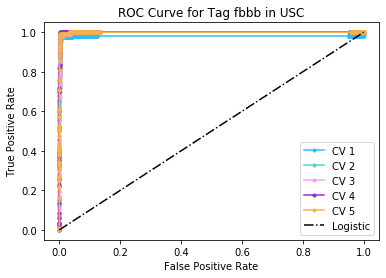

avg_sensitivity: 0.7933125852267766
avg_specificity: 0.9988392935945803
avg_f1 score: 0.7215675848196328
average_mse score: 0.0017568748740415848
avg_auc_score score: 0.99580666638932
fbonly
Selected Tag: fbonly
old columns number: 96
total number of accounts labeled with tag: 6666
total number of accounts:  168481
percentage of tags: 0.03956529222879731
['total_epay_AE17', 'total_epay_AE18', 'total_epay_AE19', 'total_epay_AE20', 'total_epay_B15', 'total_epay_B16', 'total_epay_B17', 'total_epay_B19T', 'total_epay_BS17', 'total_epay_BS18', 'total_epay_BS19', 'total_epay_CE14', 'total_epay_CE16', 'total_epay_CEF18', 'total_epay_CEF19', 'total_epay_CES18', 'total_epay_CES19', 'total_epay_CES20', 'total_epay_F14', 'total_epay_F16', 'total_epay_F17', 'total_epay_GC13', 'total_epay_GC14', 'total_epay_GC17', 'total_epay_GC18', 'total_epay_GC19', 'total_epay_PB16', 'total_epay_PB17', 'total_epay_PB19', 'total_epay_PF17', 'total_epay_PF18', 'total_epay_PF19', 'total_epay_PICF20', 'total_epay_PO

/opt/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1747: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/opt/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1800: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/opt/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1747: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/opt/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1800: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/opt/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1747: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))


         Current function value: 0.053009
         Iterations: 35
         Function evaluations: 55
         Gradient evaluations: 45


/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


                           Logit Regression Results                           
Dep. Variable:                    tag   No. Observations:               168481
Model:                          Logit   Df Residuals:                   168464
Method:                           MLE   Df Model:                           16
Date:                Wed, 02 Jun 2021   Pseudo R-squ.:                  0.6817
Time:                        08:17:10   Log-Likelihood:                -8930.9
converged:                      False   LL-Null:                       -28062.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
total_epay_B18    -0.0020      0.000     -5.148      0.000      -0.003      -0.001
total_epay_B19    -0.0019      0.001     -3.066      0.002      -0.003      -0.001
total_epay_F18     0.0008   3.39e-05

/opt/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1800: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/opt/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1747: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/opt/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1800: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/opt/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1747: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.051120
         Iterations: 35
         Function evaluations: 53
         Gradient evaluations: 44
No Skill: ROC AUC=0.500
Logistic: ROC AUC=0.994
959 125 32238 375


/opt/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1747: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/opt/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1800: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/opt/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1747: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/opt/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1800: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/opt/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1747: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/opt/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1800: RuntimeWarning: divide by zero encountered in log
  re

         Current function value: 0.052502
         Iterations: 35
         Function evaluations: 58
         Gradient evaluations: 46
No Skill: ROC AUC=0.500
Logistic: ROC AUC=0.989


/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


970 150 32213 363


/opt/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1747: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/opt/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1800: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/opt/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1747: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/opt/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1800: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/opt/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1747: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/opt/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1800: RuntimeWarning: divide by zero encountered in log
  re

         Current function value: 0.053191
         Iterations: 35
         Function evaluations: 59
         Gradient evaluations: 48
No Skill: ROC AUC=0.500
Logistic: ROC AUC=0.992
940 152 32211 393


/opt/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1747: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/opt/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1800: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/opt/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1747: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/opt/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1800: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/opt/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1747: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to conver

         Current function value: 0.054873
         Iterations: 35
         Function evaluations: 53
         Gradient evaluations: 43
No Skill: ROC AUC=0.500
Logistic: ROC AUC=0.990
940 136 32227 393


/opt/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1747: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/opt/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1800: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/opt/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1747: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/opt/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1800: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/opt/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1747: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/opt/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1800: RuntimeWarning: divide by zero encountered in log
  re

         Current function value: 0.054169
         Iterations: 35
         Function evaluations: 63
         Gradient evaluations: 52
No Skill: ROC AUC=0.500
Logistic: ROC AUC=0.992


/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


930 145 32218 403
ns_fprs: [array([0., 1.]), array([0., 1.]), array([0., 1.]), array([0., 1.]), array([0., 1.])]


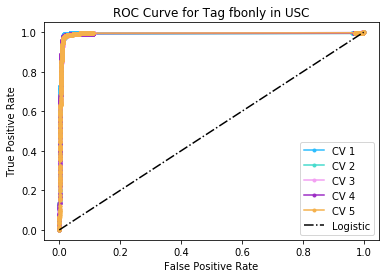

avg_sensitivity: 0.8700571726531832
avg_specificity: 0.9881805561327456
avg_f1 score: 0.7824351297171793
average_mse score: 0.01563975048601524
avg_auc_score score: 0.9913586294954373


In [104]:
tags_dict = dict()
for tag in ["fbbb","fbonly"]:
    print(tag)
    result= calculate_season_slm(tag, org)
#     break
#     print(result)
    if result!=0:
        tags_dict[tag] = result
    

In [65]:
useful_tags


['fbonly',
 'advckN',
 'calN',
 'sc',
 'cust',
 'faNm',
 'cm',
 'ath',
 'fbbb',
 'midname',
 'gcNgcNmdN',
 'uNps',
 'uN',
 'fNoptout',
 'advaddN',
 'elsfailureN',
 'itrans']

In [24]:
df[df.total_epay_F18>0]

,level_0,index,account_id,org_id,tag,total_epay_B18,total_epay_B19,total_epay_F18,total_epay_F19T,total_epay_F20,...,e_oqty_FB19,e_oqty_FC18,e_oqty_FC19,e_oqty_P18,e_oqty_P19,e_oqty_RW18,e_oqty_RW19,e_oqty_RW20,e_oqty_SCTG19,intercept
25,2144,3406,808702.0,OKLAHOMA,False,0.0,0.0,2500.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,1
36,12769,19497,823486.0,OKLAHOMA,False,0.0,0.0,1940.0,1940.0,0.0,...,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,1
56,15724,23973,264575.0,OKLAHOMA,False,0.0,0.0,1250.0,1270.0,648.1,...,0.0,0.0,0.0,1.0,0.0,4.0,2.0,0.0,0.0,1
67,1676,2671,810310.0,OKLAHOMA,False,0.0,0.0,270.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
110,15651,23850,940444.0,OKLAHOMA,False,0.0,0.0,970.0,970.0,0.0,...,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7154,9225,26717,928204.0,OKLAHOMA,True,320.0,300.0,1130.0,1150.0,0.0,...,0.0,0.0,0.0,1.0,1.0,2.0,0.0,0.0,0.0,1
7155,4859,14135,2812.0,OKLAHOMA,True,0.0,0.0,1250.0,1270.0,0.0,...,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,1
7156,3264,9515,810886.0,OKLAHOMA,True,0.0,0.0,1940.0,1940.0,2250.0,...,0.0,8.0,8.0,7.0,6.0,3.0,4.0,4.0,24.0,1
7157,9845,28490,4228.0,OKLAHOMA,True,0.0,0.0,5380.0,6180.0,3950.0,...,56.0,12.0,20.0,15.0,12.0,8.0,8.0,8.0,24.0,1


## Format Result (optional)

In [124]:
def format_model_result(tags_dict, sort_by_cols=["avg_sensitivity","avg_specificity"]):
    temp = []
    for k,v in tags_dict.items():
        tags_dict[k]["tag"]=k
        temp.append(tags_dict[k])
    tags_dict = pd.DataFrame(temp)
    return tags_dict.sort_values(by = sort_by_cols,ascending = False)

## Show Result

In [125]:
format_model_result(tags_dict, ["avg_sensitivity","avg_specificity"]).to_csv(f"tag/prediction_result_{org}.csv")

In [31]:
[0,1,2,3,4][3,5]
[xs[c] for c in sorted_idx]

TypeError: list indices must be integers or slices, not tuple